# Electrophysiology demo

This tutorial demonstrates how to access an NWB file from the [DANDI:001264](https://dandiarchive.org/dandiset/001264/draft) dataset using `pynwb`.

This dataset contains extracellular electrophysiology recordings from rats performing a value-based decision-making task. 

Neural data were acquired using Neuropixels probes (384 channels, 30 kHz sampling rate) with Neuropix-PXI hardware and OpenEphys, and preprocessed using Kilosort 2.5 with manual curation in Phy. 

Trials were initiated by a nose-poke in a lit center port and required maintaining a center fixation for 0.8 to 1.2 seconds, during which a tone indicated the possible reward size. A subsequent side LED indicated the potential reward location, followed by a delay period drawn from an exponential distribution (mean = 2.5 s). Rats could opt out at any time by poking the unlit port, restarting the trial. Catch trials, where the delay period only ended if the rat opted out, constituted 15-25% of the trials. Rats received penalties for premature fixation breaks. Additionally, the tasks introduced semi-observable hidden states by varying reward statistics across uncued blocks (high, low, and mixed), structured hierarchically, with blocks transitioning after 40 successfully completed trials.

# Reading an NWB file

This section demonstrates how to read an NWB file using `pynwb`.
Based on the [NWB File Basics](https://pynwb.readthedocs.io/en/stable/tutorials/general/plot_file.html#sphx-glr-tutorials-general-plot-file-py) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

An [NWBFile](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile) represents a single session of an experiment. Each NWBFile must have a `session description`, `identifier`, and `session start time`.

Reading is carried out using the [NWBHDF5IO](https://pynwb.readthedocs.io/en/stable/pynwb.html#pynwb.NWBHDF5IO) class. To read the NWB file use the read mode "r" to retrieve an NWBFile object.

In [1]:
from pynwb import NWBHDF5IO
import ndx_structured_behavior

nwbfile_path = "/Volumes/T9/Constantinople/nwbfiles/J076_2023-12-12_14-52-04.nwb"
io = NWBHDF5IO(nwbfile_path, load_namespaces=True)
nwbfile = io.read()


# Streaming an NWB file

This section demonstrates how to access the files on the [DANDI Archive](https://dandiarchive.org) without downloading them. Based on the [Streaming NWB files](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

The `dandi.dandiapi.DandiAPIClient` can be used to get the S3 URL of the NWB file stored in the DANDI Archive.


In [3]:
# from dandi.dandiapi import DandiAPIClient

# client = DandiAPIClient.for_dandi_instance("dandi")

# dandiset_id = "001264"
# file_path = "sub-J076/sub-J076_ecephys.nwb"

# with DandiAPIClient() as client:
#     asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
#     s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)


We will use `remfile` for streaming the file. You can read more about `remfile` at [this tutorial section](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html#method-3-remfile).

In [4]:
# import h5py
# from pynwb import NWBHDF5IO
# import remfile

# # We stream the file using remfile and open it with h5py and pynwb
# file = remfile.File(s3_url)
# h5_file = h5py.File(file, "r")
# io = NWBHDF5IO(file=h5_file, load_namespaces=True)

# nwbfile = io.read()

Importantly, the session start time is the reference time for all timestamps in the file. For instance, an event with a timestamp of 0 in the file means the event occurred exactly at the session start time.

In [4]:
nwbfile.session_start_time

datetime.datetime(2023, 12, 12, 14, 53, 12, tzinfo=tzoffset(None, -18000))

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWBFile.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.

In [5]:
nwbfile.subject

subject pynwb.file.Subject at 0x5090464480
Fields:
  age: TBD
  age__reference: birth
  sex: U
  species: Rattus norvegicus
  subject_id: J076

# Access Recording

This section demonstrates how to access the raw `ElectricalSeries` data.

`NWB` organizes data into different groups depending on the type of data. Groups can be thought of as folders within the file. Here are some of the groups within an NWBFile and the types of data they are intended to store:

- `acquisition`: raw, acquired data that should never change
- `processing`: processed data, typically the results of preprocessing algorithms and could change

## Raw ElectricalSeries

The raw ElectricalSeries data is stored in an [pynwb.ecephys.ElectricalSeries](https://pynwb.readthedocs.io/en/stable/pynwb.ecephys.html#pynwb.ecephys.ElectricalSeries) object which is added to `nwbfile.acquisition`. The data can be accessed as `nwbfile.acquisition["ElectricalSeries"]`.

The data in `ElectricalSeries` is stored as a two dimensional array: the first dimension is time, the second dimension represents electrodes/channels.


In [6]:
electrical_series = nwbfile.acquisition["ElectricalSeries"]

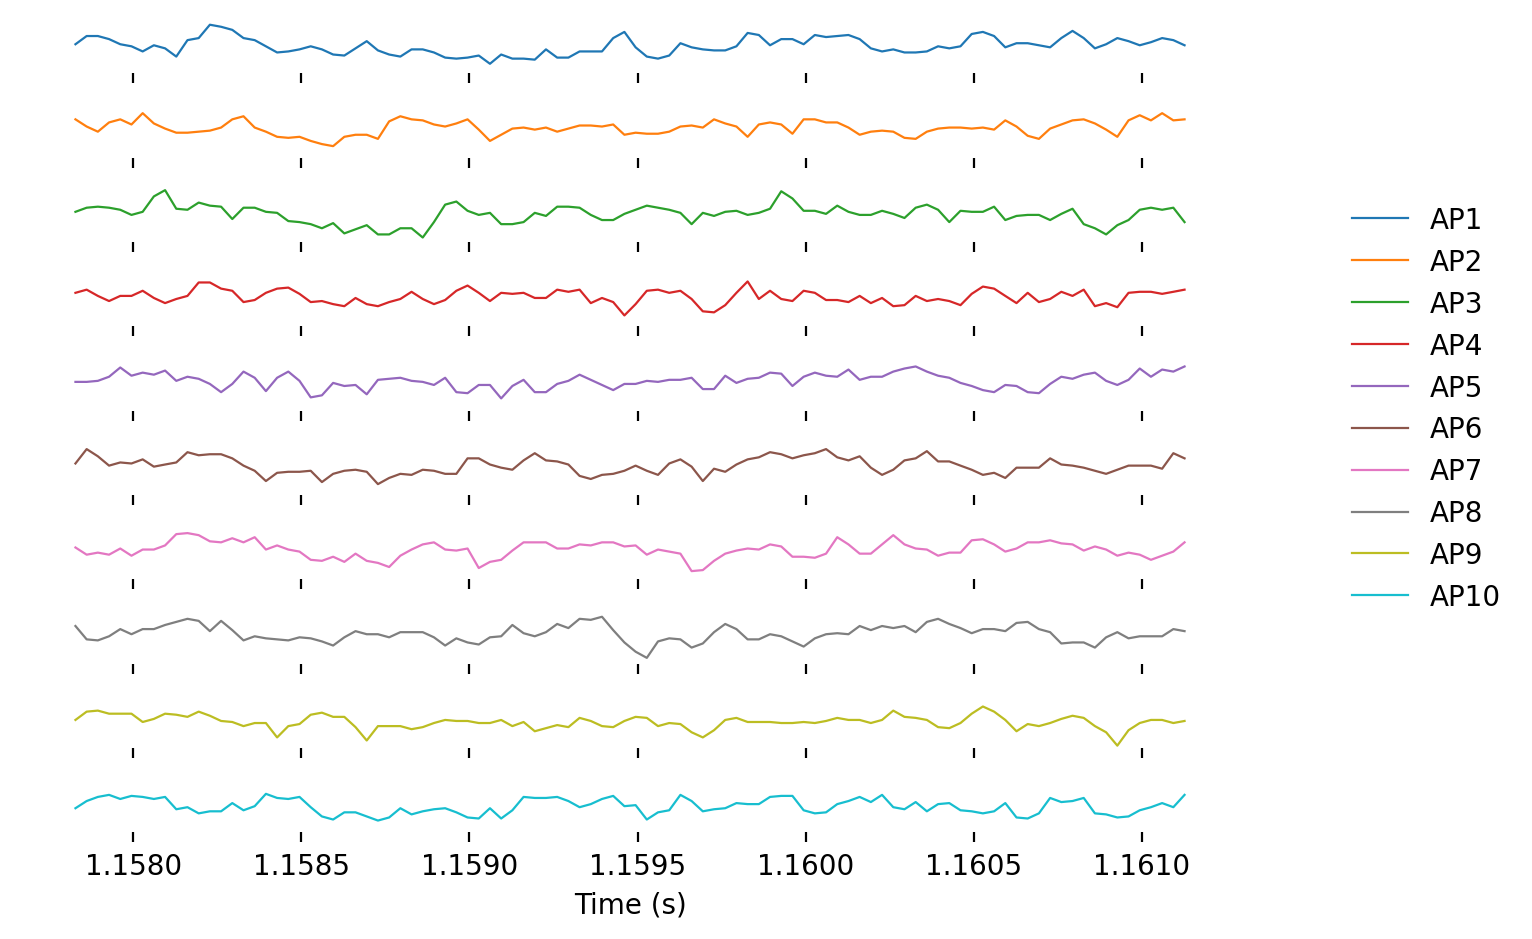

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
data = electrical_series.data[:1000, :10]
timestamps = electrical_series.get_timestamps()[:1000]
df = pd.DataFrame(data)
df["Time (s)"] = timestamps
df.set_index("Time (s)", inplace=True)
df.columns.name = "electrodes"
channel_name_mapper = dict(zip(df.columns, electrical_series.electrodes["channel_name"][:]))
df.rename(channel_name_mapper, axis=1, inplace=True)

fig, axes = plt.subplots(nrows=len(df.columns), sharex=True, sharey=True, dpi=200)
lines = df.plot(subplots=True, ax=axes, legend=False, linewidth=0.8)

# Hide y-axis labels
for ax in axes:
    ax.yaxis.set_visible(False)

# Remove box around the plots
for ax in axes:
    ax.set_frame_on(False)

# Get handles and labels for all lines
handles, labels = [], []
for line in lines:
    h, l = line.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a single legend box
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 0.8), frameon=False)
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

The electrodes table describe the electrodes that generated this data. Extracellular electrodes are stored in an "electrodes" table, which is a [DynamicTable](https://hdmf.readthedocs.io/en/stable/hdmf.common.table.html#hdmf.common.table.DynamicTable) and can be can be converted to a pandas DataFrame for convenient analysis using `nwbfile.electrodes.to_dataframe()`.

In [8]:
nwbfile.electrodes.to_dataframe().head()

,location,group,group_name,channel_name,channel_depth_um
id,,,,,
0,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at...,ElectrodeGroup,AP1,NaN
1,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at...,ElectrodeGroup,AP2,NaN
2,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at...,ElectrodeGroup,AP3,NaN
3,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at...,ElectrodeGroup,AP4,NaN
4,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at...,ElectrodeGroup,AP5,NaN


## Filtered ElectricalSeries


The processed ecephys data is stored in "processing/ecephys" which can be accessed as `nwbfile.processing["ecephys"]`.
Within this processing module we can access the container of filtered traces as `nwbfile.processing["ecephys"]["LFP"]` which can hold multiple processed `ElectricalSeries` objects.

In [9]:
nwbfile.processing["ecephys"]

,location,group,group_name,channel_name,channel_depth_um
id,,,,,
0,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at 0x5093309664\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x5082001440\nFields:\n description: no description\n\n location: unknown\n,ElectrodeGroup,AP1,NaN
1,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at 0x5093309664\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x5082001440\nFields:\n description: no description\n\n location: unknown\n,ElectrodeGroup,AP2,NaN
2,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at 0x5093309664\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x5082001440\nFields:\n description: no description\n\n location: unknown\n,ElectrodeGroup,AP3,NaN
3,unknown,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at 0x5093309664\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x5082001440\nFields:\n description: no description\n\n location: unknown\n,ElectrodeGroup,AP4,NaN
,spike_times,unit_name,original_cluster_id,ch,channel_depth_um
id,,,,,
0,"[1.229560964152963, 1.3083609641529605, 1.4348276308196297, 1.4672942974862941, 1.4885942974862942, 1.5085276308196285, 1.5370609641529605, 1.9147276308196304, 2.9152609641529637, 3.4175942974862963, 3.556427630819627, 3.7128942974862937, 6.825294297486295, 8.262494297486299, 8.427660964152963, 9.064727630819633]",0,24,372,3890
1,"[1.2434276308196281, 1.25942763081963, 1.289860964152961, 1.3444276308196272, 1.4091276308196292, 1.4391942974862957, 1.4915942974862944, 1.5288276308196274, 1.5398942974862955, 1.5534276308196304, 1.560760964152962, 1.570360964152961, 1.587760964152963, 1.647494297486297, 1.687094297486297, 1.7204276308196285, 1.784694297486297, 1.8675609641529611, 1.897660964152962, 1.9601276308196276, 1.9868609641529602, 2.0486276308196274, 2.0730276308196274, 2.0811609641529607, 2.1615609641529616, 2.200594297486294, 2.2463276308196285, 2.335027630819628, 2.47732763081963, 2.7047276308196295, 2.733760964152964, 2.765194297486296, 2.7775942974862957, 2.79912763081963, 2.816094297486295, 2.894660964152962, 2.9151609641529603, 2.916060964152962, 2.9419276308196274, 2.9548276308196293, 2.9864276308196303, 3.003494297486295, 3.0837609641529617, 3.1048942974862968, 3.139594297486294, 3.1760609641529634, 3.204294297486296, 3.212060964152961, 3.2399942974862945, 3.284960964152962, 3.3018609641529615, 3.3212609641529625, 3.3363942974862937, 3.3583942974862957, 3.3937276308196296, 3.460694297486299, 3.4811276308196284, 3.525027630819629, 3.5486609641529583, 3.5714276308196276, 3.631994297486294, 3.7373609641529626, 3.7551276308196293, 3.7964609641529634, 3.8401609641529646, 3.903260964152963, 4.00472763081963, 4.020827630819632, 4.048127630819629, 4.07676096415296, 4.112960964152961, 4.19276096415296, 4.245194297486293, 4.260094297486297, 4.279060964152961, 4.284560964152959, 4.293727630819632, 4.3014276308196315, 4.314594297486295, 4.329460964152965, 4.340994297486297, 4.357760964152959, 4.367760964152964, 4.373960964152964, 4.38122763081963, 4.402727630819626, 4.4131276308196306, 4.4190276308196275, 4.434427630819627, 4.449994297486299, 4.4625609641529635, 4.475760964152961, 4.49156096415296, 4.501160964152959, 4.513527630819631, 4.5315942974862935, 4.539627630819631, 4.567527630819626, 4.579594297486295, 4.604627630819628, ...]",1,25,376,3930
2,"[9.347527630819627, 9.576494297486292, 9.643327630819627, 9.664194297486297, 9.73236096415296, 9.79486096415296, 9.851260964152964, 9.883660964152966, 9.914327630819628, 9.971094297486296, 10.01576096415296, 10.061594297486295, 10.092560964152966, 10.16482763081963]",2,40,340,3570


In [16]:
    processed_ecephys = nwbfile.processing["ecephys"]["LFP"]

filtered_electrical_series = processed_ecephys["ElectricalSeries"]
filtered_electrical_series

,location,group,group_name,channel_name,rel_x,inter_sample_shift,rel_y,channel_depth_um,width,contact_shapes
id,,,,,,,,,,
0,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x6075195872\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x6075383104\nFields:\n description: no description\n\n location: unknown\n,0,AP1,27.0,0.000000,3840.0,NaN,12.0,square
1,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x6075195872\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x6075383104\nFields:\n description: no description\n\n location: unknown\n,0,AP2,59.0,0.000000,3840.0,NaN,12.0,square
2,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x6075195872\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x6075383104\nFields:\n description: no description\n\n location: unknown\n,0,AP3,11.0,0.076923,3860.0,NaN,12.0,square
3,unknown,0 pynwb.ecephys.ElectrodeGroup at 0x6075195872\nFields:\n description: no description\n device: DeviceEcephys pynwb.device.Device at 0x6075383104\nFields:\n description: no description\n\n location: unknown\n,0,AP4,43.0,0.076923,3860.0,NaN,12.0,square


# Access Units

Spike times are stored in the `Units` table, which is a DynamicTable and can be can be converted to a pandas DataFrame for convenient analysis using `nwbfile.units.to_dataframe()`.


In [18]:
nwbfile.units[:].head()

,spike_times,unit_name,ch,sh,amp,n_spikes,quality,original_cluster_id,Amplitude,fr,depth,KSLabel,ContamPct
id,,,,,,,,,,,,,
0,"[20.509433333333334, 20.5924, 20.8509, 20.936,...",0,74,0,66.992470,691,nan,0,2031.3,0.103813,1600.0,mua,335.4
1,"[5.534833333333333, 11.725933333333334, 14.853...",1,105,0,75.382370,1748,nan,1,940.9,0.262612,1900.0,mua,152.4
2,"[20.592466666666667, 20.935966666666666, 21.27...",2,105,0,82.178314,278,nan,2,5098.0,0.041765,1900.0,mua,495.3
3,"[175.66426666666666, 237.11613333333332, 423.7...",3,125,0,59.803703,34,nan,3,680.2,0.005108,2100.0,mua,inf
4,"[1.5859, 3.782366666666667, 4.171866666666666,...",4,133,0,36.706387,17856,nan,4,476.2,2.682606,2180.0,mua,99.4


# Access raw behavior data

This section demonstrates how to access the Bpod data in the NWBFile.

## Accessing the task metadata

The task-related general metadata is stored in a `Task` object which can be accessed as `nwbfile.lab_meta_data["task"]`.

The `EventTypesTable` is a column-based table to store the type of events that occur during the task (e.g. port poke from the animal), one type per row.
This table can be accessed as `nwbfile.lab_meta_data["task"].event_types`.


In [10]:
nwbfile.lab_meta_data["task"].event_types[:]

,event_name
id,
0,state_timer
1,left_port_poke
2,center_port_poke
3,right_port_poke


The `ActionTypesTable` is a column-based table to store the type of actions that occur during the task (e.g. sound output from the acquisition system), one type per row.
This table can be accessed as `nwbfile.lab_meta_data["task"].action_types`.

In [11]:
nwbfile.lab_meta_data["task"].action_types[:]

,action_name
id,
0,sound_output


The `StateTypesTable` is a column-based table to store the type of states that occur during the task (e.g. while the animal is waiting for reward), one type per row.
This table can be accessed as `nwbfile.lab_meta_data["task"].state_types`.

In [12]:
nwbfile.lab_meta_data["task"].state_types[:]

,state_name
id,
0,go_cue
1,nose_in_center
2,announce_reward
3,wait_for_poke
4,stop_sound
5,wait_for_side_poke
6,opt_out
7,reward
8,punish_violation


The arguments for the task is stored in a `TaskArgumentsTable` which can be accessed as `nwbfile.lab_meta_data["task"].task_arguments`.


In [13]:
nwbfile.lab_meta_data["task"].task_arguments[:]

,argument_name,argument_description,expression,expression_type,output_type
id,,,,,
0,reward_volume_ul,The volume of reward in microliters.,5,integer,numeric
1,nose_in_center,The time in seconds when the animal is require...,1.0953925215757918,double,numeric
2,time_increment_for_nose_in_center,The time increment for nose in center in seconds.,0,double,numeric
3,target_duration_for_nose_in_center,The goal for how long the animal must poke cen...,1,double,numeric
4,training_stage,The stage of the training.,9,integer,numeric
5,reward_delay,"The delay in seconds to receive reward, drawn ...",100,double,numeric
6,target_reward_delay,The target delay in seconds to receive reward.,1.5,double,numeric
7,time_increment_for_reward_delay,The time increment during monotonic increase o...,0.025,double,numeric
8,violation_time_out,The time-out if nose is center is not satisfie...,1,double,numeric


The `TaskRecording` object stores the data for events, states, and actions that occured during the task. The `TaskRecording` is added as acquisition which can be accessed as `nwbfile.acquisition["task_recording"]`.

The `EventsTable` is a column-based table to store the information about the events (e.g. poke times), one event per row. This table can be accessed as `nwbfile.acquisition["task_recording"].events`.

In [14]:
import pandas as pd

pd.merge(
    nwbfile.acquisition["task_recording"].events[:],
    nwbfile.lab_meta_data["task"].event_types[:],
    left_on="event_type",
    right_on="id",
)

,timestamp,event_type,value,event_name
0,38.5442,2,In,center_port_poke
1,38.6237,2,Out,center_port_poke
2,39.6237,0,Expired,state_timer
3,39.8822,1,In,left_port_poke
4,40.0315,1,In,left_port_poke
...,...,...,...,...
8682,6313.5514,2,Out,center_port_poke
8683,6314.3740,0,Expired,state_timer
8684,6315.0374,2,In,center_port_poke
8685,6315.4097,2,Out,center_port_poke


The `ActionsTable` is a column-based table to store the information about the actions (e.g. sound onset times), one action per row. This table can be accessed as `nwbfile.acquisition["task_recording"].actions`.

In [15]:
pd.merge(
    nwbfile.acquisition["task_recording"].actions[:],
    nwbfile.lab_meta_data["task"].action_types[:],
    left_on="action_type",
    right_on="id",
).head()

,timestamp,action_type,value,action_name
0,19.9881,0,On,sound_output
1,20.1782,0,On,sound_output
2,38.5443,0,On,sound_output
3,38.6238,0,On,sound_output
4,39.1240,0,On,sound_output


The `StatesTable` is a column-based table to store the information about the states (e.g. the duration while nose is in center port). This table can be accessed as `nwbfile.acquisition["task_recording"].states`.

In [16]:
pd.merge(
    nwbfile.acquisition["task_recording"].states[:],
    nwbfile.lab_meta_data["task"].state_types[:],
    left_on="state_type",
    right_on="id",
).head()

,start_time,stop_time,state_type,state_name
0,19.9880,38.5442,3,wait_for_poke
1,38.5442,38.6237,1,nose_in_center
2,38.6237,39.6237,8,punish_violation
3,39.7154,42.2451,3,wait_for_poke
4,42.2451,42.5430,1,nose_in_center


### Plot the events, actions, and states

The ``plot_events``, ``plot_actions``, and ``plot_states`` functions can consume both the raw table as well as a subset of the table as a pandas DataFrame created through slicing, e.g., via ``events[:100]`` will plot only the first 100 rows from the events table.

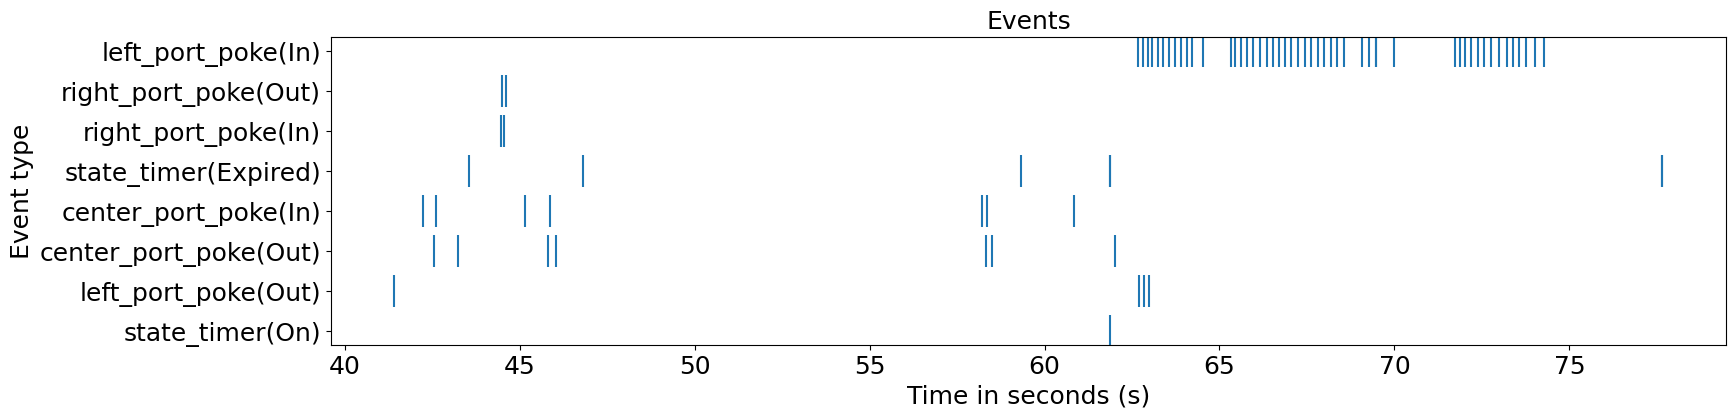

In [17]:
from matplotlib import pyplot as plt
from ndx_structured_behavior.plot import plot_events, plot_actions, plot_states, plot_trials

# Get the events from file
events = nwbfile.get_acquisition("task_recording").events
event_types = nwbfile.get_lab_meta_data("task").event_types

# Plot the data
fig = plot_events(
    events=events[20:100],
    event_types=event_types,
    show_event_values=True,
    figsize=(18,4),
    marker_size=500,
)
plt.title("Events", fontsize=18)
plt.show()

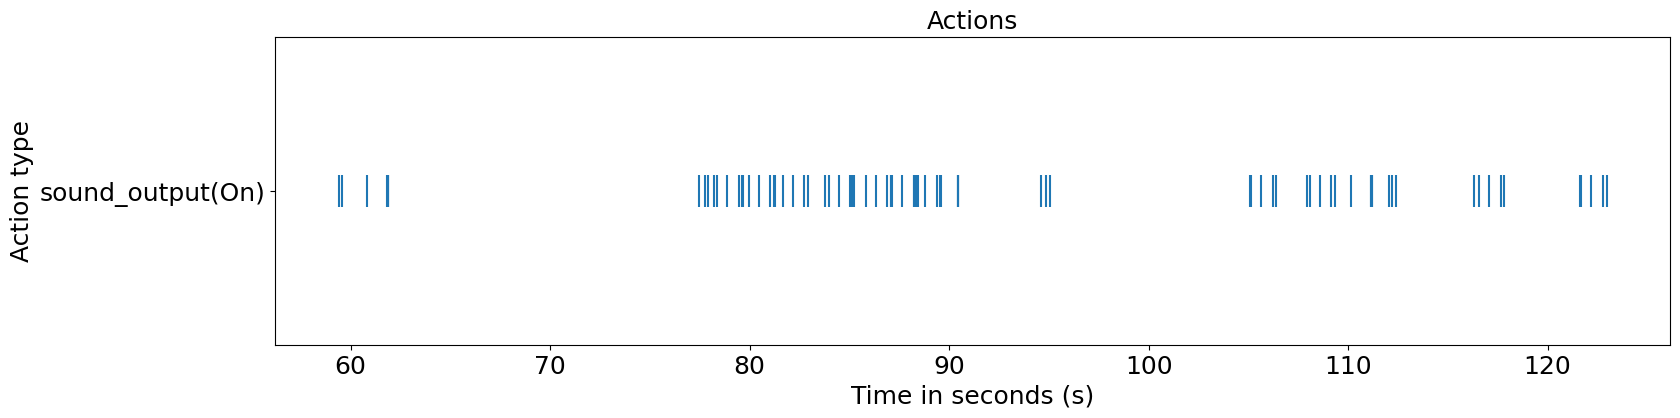

In [18]:
# Get the actions from file
actions = nwbfile.get_acquisition("task_recording").actions
action_types = nwbfile.get_lab_meta_data("task").action_types

# Plot the data
fig = plot_actions(
    actions=actions[20:100],
    action_types=action_types,
    figsize=(18,4),
    marker_size=500,
)
plt.title("Actions", fontsize=18)
plt.show()

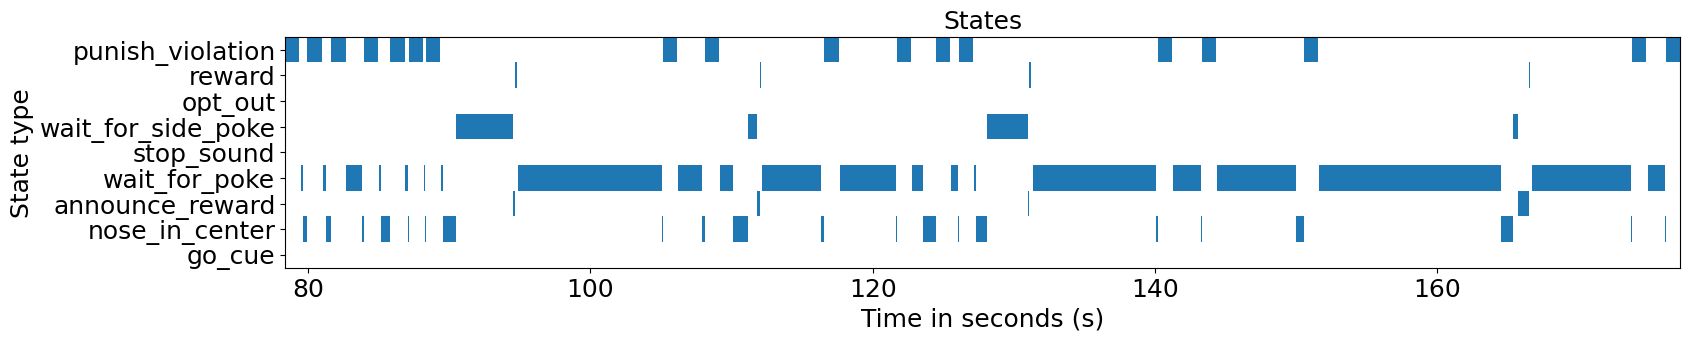

In [19]:
# Get the states from file
states = nwbfile.get_acquisition("task_recording").states
state_types = nwbfile.get_lab_meta_data("task").state_types

# Plot the data
plot_states(states=states[20:100],
            state_types=state_types,
            marker_size=500)
plt.title("States", fontsize=18)
plt.show()

## Accessing the trials

The `TrialsTable` is a column-based table to store information about trials, one trial per row.
The table can be accessed from the file as `nwbfile.trials`.


In [20]:
trials = nwbfile.trials

trials[:].head()

,start_time,stop_time,states,events,actions,trials_in_stage,changed,cycle_blocks,target_reward_delay,catch_percentage,...,num_trials_in_adaptation_blocks,is_catch,punish_sound_enabled,nose_in_center,target_duration_for_nose_in_center,is_warm_up,num_trials_in_test_blocks,block_type,previous_was_violation,center_port_cue
id,,,,,,,,,,,,,,,,,,,,,
0,19.9880,39.6237,"[0, 1]","[0, 1]","[0, 1, 2, 3, 4]",129054,False,True,1.5,0.25,...,40,False,True,1.095400,1,False,40,Mixed,False,False
1,39.7154,43.5430,"[3, 4]","[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[5, 6, 7, 8, 9]",129056,False,True,1.5,0.25,...,40,True,True,1.188173,1,False,40,Mixed,True,False
2,43.6313,46.8007,"[6, 7]","[26, 27, 28, 29, 30, 31, 32, 33]","[10, 11, 12, 13, 14]",129057,False,True,1.5,0.25,...,40,False,True,1.188173,1,False,40,Mixed,True,False
3,46.8732,59.3249,"[9, 10]","[35, 36, 37, 38]","[15, 16, 17, 18, 19]",129058,False,True,1.5,0.25,...,40,True,True,1.109749,1,False,40,Mixed,True,False
4,59.4011,77.6604,"[12, 13, 14, 15, 16]","[40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 5...","[20, 21, 22, 23, 24, 25, 26, 27]",129059,False,True,1.5,0.25,...,40,True,True,1.018144,1,False,40,Mixed,True,False


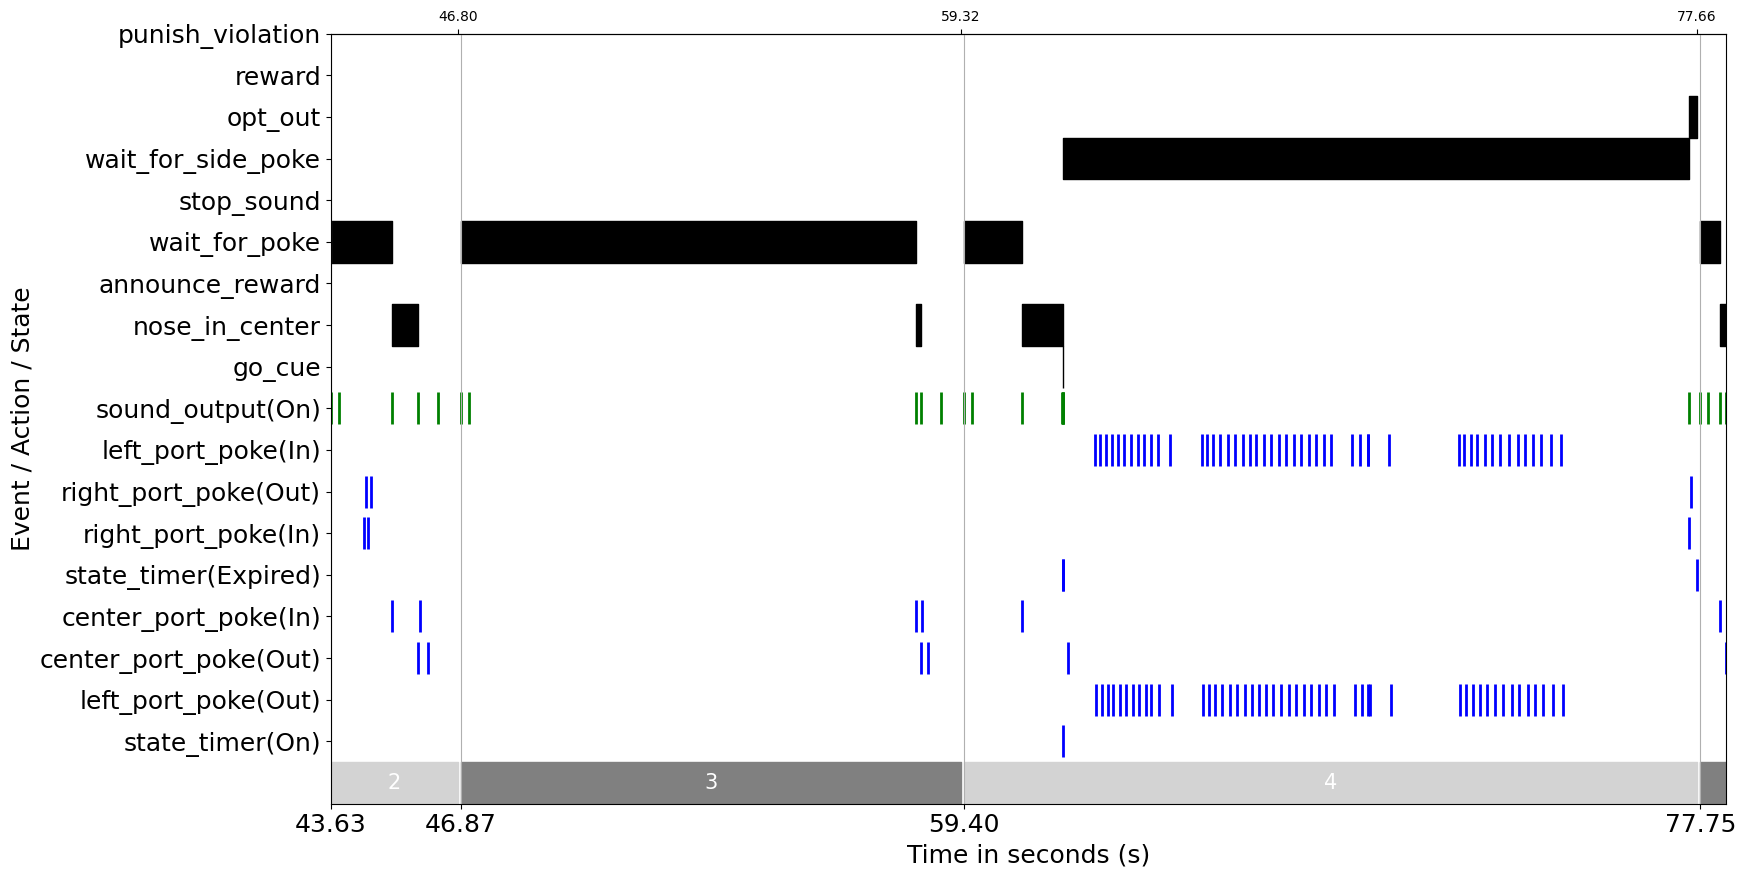

In [21]:
# Plot trial 2 - 5
plot_trials(
    trials=trials[2:6],
    states=states, state_types=state_types,
    actions=actions, action_types=action_types,
    events=events, event_types=event_types,
    figsize=None,
    fontsize=18,
    rectangle_height=1,
    marker_size=500)
plt.show()

# Access processed behavior data

This section demonstrates how to access the processed behavior data in the NWBFile.
The table can be accessed from the file as `nwbfile.intervals["processed_trials"]`.

In [24]:
nwbfile.intervals["processed_trials"][:]

,start_time,stop_time,center_poke_onset_time,center_poke_offset_time,nose_in_center,training_stage,block_type,num_trials_in_adaptation_blocks,num_trials_in_test_blocks,catch_percentage,...,is_opt_out,wait_time,rewarded_port,left_poke_times,right_poke_times,left_opt_out_times,right_opt_out_times,reaction_time,short_latency_reaction_time,inter_trial_interval
id,,,,,,,,,,,,,,,,,,,,,
0,19.9880,39.6237,48.570172,67.126643,1.095400,9,Mixed,40,40,0.25,...,False,NaN,Right,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,18.5562
1,39.7154,43.5430,68.297872,70.827609,1.188173,9,Mixed,40,40,0.25,...,False,NaN,Left,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,2.5297
2,43.6313,46.8007,72.213823,73.734469,1.188173,9,Mixed,40,40,0.25,...,False,NaN,Left,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,1.5206
3,46.8732,59.3249,75.455781,86.787184,1.109749,9,Mixed,40,40,0.25,...,False,NaN,Left,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,11.3312
4,59.4011,77.6604,87.983920,89.428742,1.018144,9,Mixed,40,40,0.25,...,True,15.5943,Left,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[90.4488554055054, 106.04339712480126, 106.043...",NaN,0.8094,1.4448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,6237.8301,6265.6915,6266.513190,6293.131314,1.184658,9,High,40,40,0.25,...,False,NaN,Left,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,26.6177
480,6266.2179,6268.1972,6294.901438,6295.369935,1.135084,9,High,40,40,0.25,...,False,NaN,Right,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,0.4685
481,6268.7188,6311.9109,6297.402369,6339.474865,0.848517,9,High,40,40,0.25,...,False,NaN,Right,"[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,42.0718
